### This notebook is to explore and develop functionality to output our downsampled imagery as COGeoTIFF

In [84]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\data")
    #sys.path.insert(0, module_path+"\\src\\data")
    
import downSampler # load pipeline module

In [85]:
# other useful libraries

import json
import h5py
import gdal
gdal.UseExceptions()
import itertools
import pystac
import geojson as gj
import numpy as np

### Lets look at our generated file

In [86]:
input_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files

In [87]:
input_file_dict  = downSampler.find_files(input_data_path)
input_file_dict

Finding data files...


{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.

In [88]:
output_file_dict = downSampler.find_files(output_data_path)
output_file_dict

Finding data files...


{'cube_output_TEST_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\cube_output_TEST_1.h5',
 'splitbands_output_TEST_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_1.h5',
 'splitbands_output_TEST_2.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_2.h5',
 'TEST_output_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\TEST_output_1.h5',
 'TEST_output_Geo1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\TEST_output_Geo1.h5',
 'Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\hdf5_downsampled\\Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5',
 'Wyvern_D10_RMNP_

### Check the input data structure

In [89]:
in_keys_ls = list(input_file_dict.keys())
in_keys_ls
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(input_file_dict[in_keys_ls[0]])

	 - ABBY : <HDF5 group "/ABBY" (1 members)>
		 - Reflectance : <HDF5 group "/ABBY/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/ABBY/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/ABBY/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : b'AOT (aerosol optical thickness at 550 nm)*1000'
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aerosol Optical Depth at 500 nm.'
							 - Scale_Factor : 1000.0
							 - Units : b'Aerosol Optical Depth at 500 nm.'
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aspect used as input to ATCOR'
							 - Dimension_Labels : b'-'
							 - Scale_Factor : 1.0
							 - Units : b'degrees'
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ign

In [90]:
out_keys_ls = list(output_file_dict.keys())
out_keys_ls
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(output_file_dict[out_keys_ls[1]])

	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 505000.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_002 : <HDF5 dataset "Band_002": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 526000.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_003 : <HDF5 dataset "Band_003": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 54400

### Dig into Coordinate Reference System

In [10]:
print('Filename: ', in_keys_ls[0])
print('Path: ', input_file_dict[in_keys_ls[0]])

f = h5py.File(input_file_dict[in_keys_ls[0]], 'r') # read in file

Filename:  NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5
Path:  C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_input\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5


In [11]:
Coordinate_System = f['ABBY']['Reflectance']['Metadata']['Coordinate_System']
Coordinate_System.keys()

<KeysViewHDF5 ['Coordinate_System_String', 'EPSG Code', 'Map_Info', 'Proj4']>

In [12]:
# look at what is in the coordinate system string:
print(Coordinate_System['Coordinate_System_String'].shape)
print(Coordinate_System['Coordinate_System_String'].dtype)
Coordinate_System['Coordinate_System_String'][()]

()
object


b'PROJCS["UTM_Zone_10N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [13]:
# look at what is in the EPSG Code:
print(Coordinate_System['EPSG Code'].shape)
print(Coordinate_System['EPSG Code'].dtype)
Coordinate_System['EPSG Code'][()]

()
object


b'32610'

In [14]:
# look at what is in the Map Info:
print(Coordinate_System['Map_Info'].shape)
print(Coordinate_System['Map_Info'].dtype)
Coordinate_System['Map_Info'][()]

()
object


b'UTM,  1.000,  1.000,       552000.00,       5072000.0,       1.0000000,       1.0000000,  10,  North,  WGS-84,  units=Meters, 0'

In [15]:
# look at what is in the Proj4:
print(Coordinate_System['Proj4'].shape)
print(Coordinate_System['Proj4'].dtype)
Coordinate_System['Proj4'][()]

()
object


b'+proj=UTM +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

Looks like we can use this Proj4 with GDAL to help convert to Lon,Lat used in STAC spec

## Array to hdf5 raster layer image:

In [106]:
# work on the output function

def array2h5raster(refl_array, wavelength_array, FWHM_array, metadata_dict, filename_output):
    """
    Takes in a 3-D reflectance array, an array of band centre wavelengths, FWHM array,
    and an additional metadata dictionary and generates a HDF5 file with the given filename.
    Each band of reflectance data is written to its own hdf5 dataset.
    """

    # scale the reflectance data up by the original reflectance factor to save disk space
    scale_fac = metadata_dict['reflectance scale factor']
    refl_array = refl_array*scale_fac
    wavelength_array = np.array(wavelength_array)*1000 # convert to nm
    FWHM_array = np.array(FWHM_array)*1000

    hf = h5py.File(filename_output, 'w') # create hdf5 file
    g1 = hf.create_group('Reflectance') # create main group
    g2 = hf.create_group('Reflectance/Metadata') # group for metadata

    # datasets
    # ------------------------------------------------------------------------------
    # reflectance data
    
    for band in range(refl_array.shape[2]):
        #print("band",band)
        band_name = 'Band_' + str(band+1).zfill(3) # make into e.g. 001 or 013 instead of 1 or 13 etc.
        print(band_name)
        refl_dset = g1.create_dataset(band_name,data=refl_array[:,:,band], dtype='i') # dataset for each band of reflectance data
        refl_dset.attrs['Description'] =  'Atmospherically corrected reflectance.'
        refl_dset.attrs['Wavelength'] = wavelength_array[band]# wavelength in nm
        refl_dset.attrs['Wavelength_units'] = 'nm' # wavelength units
        refl_dset.attrs['data ignore value'] = metadata_dict['data ignore value']
        refl_dset.attrs['reflectance scale factor'] = metadata_dict['reflectance scale factor']
        refl_dset.attrs['Spatial_Resolution_X_Y'] = metadata_dict['Spatial_Resolution_X_Y']
        refl_dset.attrs['spatial extent'] = metadata_dict['spatial extent']

    # wavelength data
    wav_dset = g2.create_dataset('Wavelength',data=wavelength_array) # band centre wavelength data
    wav_dset.attrs['Description'] = 'Central wavelength of the reflectance bands.'
    wav_dset.attrs['Units'] = 'nanometers'

    # FWHM data
    FWHM_dset = g2.create_dataset('FWHM',data=FWHM_array) # FWHM data
    FWHM_dset.attrs['Description'] = 'Full width half maximum of reflectance bands.'
    FWHM_dset.attrs['Units'] = 'nanometers'

    # coordinates data
    g2_1 = g2.create_group('Coordinate_System') # group for metadata
    Proj4_dset = g2_1.create_dataset('Proj4',data=metadata_dict['Proj4']) # band Proj4 data
    EPSG_dset = g2_1.create_dataset('EPSG Code',data=metadata_dict['EPSG Code']) # EPSG Code
    map_dset = g2_1.create_dataset('Map_Info',data=metadata_dict['Map_Info']) # Map Info
    coor_dset = g2_1.create_dataset('Coordinate_System_String',data=metadata_dict['Coordinate_System_String']) # coordinate system
    map_dset.attrs['Description'] = ("List of geographic information in the following order:\n"
                                    "   - Projection name\n"
                                    "   - Reference (tie point) pixel x location (in file coordinates)\n"
                                    "   - Reference (tie point) pixel y location (in file coordinates)\n"
                                    "   - Pixel easting\n"
                                    "   - Pixel northing\n"
                                    "   - x pixel size\n"
                                    "   - y pixel size\n"
                                    "   - Projection zone (UTM only)\n"
                                    "   - North or South (UTM only)\n"
                                    "   - Datum\n"
                                    "   - Units\n"
                                    "   - Rotation Angle\n"
                                    )
    
    #     - Description : List of geographic information in the following order: 
    #         - Projection name
    #         - Reference (tie point) pixel x location (in file coordinates)
    #         - Reference (tie point) pixel y location (in file coordinates)
    #         - Pixel easting
    #         - Pixel northing
    #         - x pixel size
    #         - y pixel size
    #         - Projection zone (UTM only)
    #         - North or South (UTM only)
    #         - Datum
    #         - Units
    #         - Rotation Angle
    
    hf.close() # close file to save and write to disk


In [92]:
input_file_dict

{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.

In [93]:
input_file_dict[in_keys_ls[5]]

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2018-09.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5'

In [94]:
refl_array, wavelength_array, FWHM_array, metadata_dict = downSampler.h5data2array(input_file_dict[in_keys_ls[4]])

In [95]:
metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': array([1., 1.]),
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.

In [96]:
# parameter setup:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files
desired_GSD = 5 # GSD in m
desired_band_centres = 1000*np.array([0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804])
print("Parameters set!")

Parameters set!


In [97]:
desired_band_centres

array([505., 526., 544., 565., 586., 606., 626., 646., 665., 682., 699.,
       715., 730., 745., 762., 779., 787., 804.])

- Narrowed down to downsample_reband_array > line 340, rebrand_spectral array (or how it writes to rebranded_array)

- FOUND IT: Turns out that the output_band_centres_array was getting passed in in micrometers instead of nanometers. Since the scale of the output band values (used as new x values in function to try and interpolate y values from) was a few orders of magnitude less than what they should have been, they fell outside of the input bands range (used as x values). This was causing a default behaviour of the interpolate function to just return the edge y value (first one) for all the elements in the array. This had the appearance that it was setting each image data layer to be the same thing.

- FIXED IT: After setting the output_band_centres_array to nm this fixed the issue.

In [98]:
# perform downsampling
#resamp_refl_array = downSample_reband_array(refl_array, 1, 5, wavelength_array, desired_band_centres)
#resamp_refl_array = downSampler.downSample_reband_array(refl_array, 1, 5, wavelength_array, desired_band_centres) # downsample

resamp_refl_array = downSampler.downSample_reband_array(refl_array, metadata_dict['Spatial_Resolution_X_Y'][0], desired_GSD, wavelength_array, desired_band_centres) # downsample

resamp_metadata_dict = metadata_dict.copy()
resamp_metadata_dict['Spatial_Resolution_X_Y'] = [float(desired_GSD), float(desired_GSD)] # adjust resolution metadata to reflect downsampling
print("Downsampling Complete!")

Downsampling Complete!


In [99]:
resamp_refl_array.shape

(1000, 1000, 18)

In [100]:
resamp_metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': [5.0, 5.0],
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.9996]

### Start error checking code

In [30]:
input_file_dict[in_keys_ls[4]]

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2017-07.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2017_reflectance.h5'

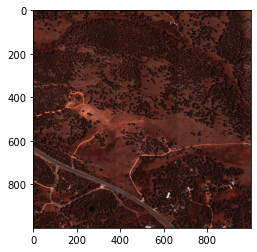

In [31]:
downSampler.toRGB(refl_array, 'QA_vis1.png', mode=1)

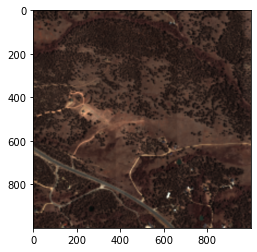

In [32]:
downSampler.toRGB(resamp_refl_array, 'QA_vis2.png', mode=2) # WYVERN_DS_20210517T162735_1KhCotz_preview

In [33]:
refl_array[:,:,0]

array([[0.0312, 0.0258, 0.0502, ..., 0.0983, 0.1427, 0.1279],
       [0.0485, 0.0391, 0.0332, ..., 0.0836, 0.1371, 0.1618],
       [0.0369, 0.0521, 0.0412, ..., 0.1082, 0.0903, 0.1135],
       ...,
       [0.0763, 0.0556, 0.035 , ..., 0.051 , 0.0373, 0.0272],
       [0.0772, 0.0562, 0.036 , ..., 0.0493, 0.0412, 0.0409],
       [0.0488, 0.045 , 0.042 , ..., 0.057 , 0.0487, 0.0364]])

In [34]:
refl_array[:,:,5]

array([[0.0139, 0.0167, 0.0204, ..., 0.0608, 0.0699, 0.0641],
       [0.0158, 0.0162, 0.0158, ..., 0.0614, 0.073 , 0.0786],
       [0.0184, 0.0136, 0.0194, ..., 0.0598, 0.0518, 0.0505],
       ...,
       [0.0359, 0.0261, 0.0197, ..., 0.0193, 0.0172, 0.0134],
       [0.0395, 0.0241, 0.0193, ..., 0.0217, 0.02  , 0.0163],
       [0.0299, 0.0228, 0.018 , ..., 0.0213, 0.0187, 0.0212]])

In [35]:
refl_array[:,:,13]

array([[0.0122, 0.0148, 0.0224, ..., 0.0647, 0.0784, 0.0718],
       [0.0118, 0.0126, 0.0162, ..., 0.065 , 0.081 , 0.0851],
       [0.0197, 0.0137, 0.0213, ..., 0.0667, 0.0576, 0.0497],
       ...,
       [0.0414, 0.0257, 0.017 , ..., 0.0175, 0.0126, 0.01  ],
       [0.0409, 0.0251, 0.0171, ..., 0.0222, 0.0221, 0.0158],
       [0.0294, 0.0195, 0.0144, ..., 0.0211, 0.0214, 0.0227]])

In [36]:
resamp_refl_array[:,:,0]

array([[0.028328, 0.025944, 0.02356 , ..., 0.06818 , 0.06774 , 0.0673  ],
       [0.029544, 0.026612, 0.02368 , ..., 0.06794 , 0.06776 , 0.06758 ],
       [0.03076 , 0.02728 , 0.0238  , ..., 0.0677  , 0.06778 , 0.06786 ],
       ...,
       [0.02788 , 0.02714 , 0.0264  , ..., 0.0162  , 0.01992 , 0.02364 ],
       [0.027756, 0.027388, 0.02702 , ..., 0.01752 , 0.021656, 0.025792],
       [0.027632, 0.027636, 0.02764 , ..., 0.01884 , 0.023392, 0.027944]])

In [37]:
resamp_refl_array[:,:,5]

array([[0.040692, 0.037156, 0.03362 , ..., 0.0944  , 0.093684, 0.092968],
       [0.042496, 0.038128, 0.03376 , ..., 0.0945  , 0.094152, 0.093804],
       [0.0443  , 0.0391  , 0.0339  , ..., 0.0946  , 0.09462 , 0.09464 ],
       ...,
       [0.04072 , 0.03946 , 0.0382  , ..., 0.021   , 0.02646 , 0.03192 ],
       [0.040484, 0.039692, 0.0389  , ..., 0.02316 , 0.029156, 0.035152],
       [0.040248, 0.039924, 0.0396  , ..., 0.02532 , 0.031852, 0.038384]])

In [38]:
resamp_refl_array[:,:,9]

array([[0.03552 , 0.02986 , 0.0242  , ..., 0.08992 , 0.089292, 0.088664],
       [0.0378  , 0.031   , 0.0242  , ..., 0.08976 , 0.089696, 0.089632],
       [0.04008 , 0.03214 , 0.0242  , ..., 0.0896  , 0.0901  , 0.0906  ],
       ...,
       [0.03566 , 0.03458 , 0.0335  , ..., 0.0153  , 0.02124 , 0.02718 ],
       [0.035888, 0.035704, 0.03552 , ..., 0.0178  , 0.024456, 0.031112],
       [0.036116, 0.036828, 0.03754 , ..., 0.0203  , 0.027672, 0.035044]])

In [39]:
# resampled input image
for band in range(resamp_refl_array.shape[2]):
    print('Band: ', band)
    print('Max: ', resamp_refl_array[:,:,band].max())
    print('Min: ', resamp_refl_array[:,:,band].min())
    print('Avg.: ', np.average(resamp_refl_array[:,:,band]))
    print('Std.: ', np.std(resamp_refl_array[:,:,band]))

Band:  0
Max:  0.36909999999998655
Min:  0.004800000000000681
Avg.:  0.040418266724
Std.:  0.019092944622430334
Band:  1
Max:  0.3707999999999865
Min:  0.0060000000000010835
Avg.:  0.049333862019999994
Std.:  0.019563187538701315
Band:  2
Max:  0.38669999999998594
Min:  0.007100000000001414
Avg.:  0.058342191855999974
Std.:  0.021532594939005445
Band:  3
Max:  0.3864999999999859
Min:  0.006000000000001407
Avg.:  0.05962474620000001
Std.:  0.023261676504310276
Band:  4
Max:  0.40019999999998546
Min:  0.004500000000001194
Avg.:  0.057569053888
Std.:  0.025897865562253323
Band:  5
Max:  0.40519999999998524
Min:  0.004000000000001141
Avg.:  0.05799937581200004
Std.:  0.02769945209162779
Band:  6
Max:  0.40419999999998524
Min:  0.003400000000001069
Avg.:  0.057678256592
Std.:  0.02947383738594284
Band:  7
Max:  0.40079999999998533
Min:  0.002900000000000984
Avg.:  0.05764834845200004
Std.:  0.031097826573398702
Band:  8
Max:  0.3950999999999855
Min:  0.0021000000000008846
Avg.:  0.055598781

In [40]:
np.round(resamp_refl_array[:,:,0],4)

array([[0.0283, 0.0259, 0.0236, ..., 0.0682, 0.0677, 0.0673],
       [0.0295, 0.0266, 0.0237, ..., 0.0679, 0.0678, 0.0676],
       [0.0308, 0.0273, 0.0238, ..., 0.0677, 0.0678, 0.0679],
       ...,
       [0.0279, 0.0271, 0.0264, ..., 0.0162, 0.0199, 0.0236],
       [0.0278, 0.0274, 0.027 , ..., 0.0175, 0.0217, 0.0258],
       [0.0276, 0.0276, 0.0276, ..., 0.0188, 0.0234, 0.0279]])

In [41]:
np.round(resamp_refl_array[:,:,0],4)

array([[0.0283, 0.0259, 0.0236, ..., 0.0682, 0.0677, 0.0673],
       [0.0295, 0.0266, 0.0237, ..., 0.0679, 0.0678, 0.0676],
       [0.0308, 0.0273, 0.0238, ..., 0.0677, 0.0678, 0.0679],
       ...,
       [0.0279, 0.0271, 0.0264, ..., 0.0162, 0.0199, 0.0236],
       [0.0278, 0.0274, 0.027 , ..., 0.0175, 0.0217, 0.0258],
       [0.0276, 0.0276, 0.0276, ..., 0.0188, 0.0234, 0.0279]])

### End error checking code

In [44]:
desired_band_centres

array([505., 526., 544., 565., 586., 606., 626., 646., 665., 682., 699.,
       715., 730., 745., 762., 779., 787., 804.])

In [107]:
# save to raster hdf5
refl_arrayname_output =  Path(output_data_path / 'splitbands_output_TEST_1.h5')
band_width_array = downSampler.band_widths(desired_band_centres)
array2h5raster(resamp_refl_array, desired_band_centres, band_width_array, metadata_dict, refl_arrayname_output)

Band_001
Band_002
Band_003
Band_004
Band_005
Band_006
Band_007
Band_008
Band_009
Band_010
Band_011
Band_012
Band_013
Band_014
Band_015
Band_016
Band_017
Band_018


In [108]:
# test outputted file
#Path("C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5")
downSampler.h5dump(refl_arrayname_output)

	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 505000.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_002 : <HDF5 dataset "Band_002": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 526000.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_003 : <HDF5 dataset "Band_003": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 54400

In [45]:
print(out_keys_ls)
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(output_file_dict[out_keys_ls[1]])

['cube_output_TEST_1.h5', 'splitbands_output_TEST_1.h5', 'splitbands_output_TEST_2.h5', 'TEST_output_1.h5', 'TEST_output_Geo1.h5', 'Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5', 'Wyvern_D10_RMNP_DP3_459000_4448000_2018_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5071000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5072000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5073000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5074000_reflectance_downsampled_4mGSD.h5']
	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [1. 1.]
				 - Wavelength : 505000.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 

In [102]:
# write out hdf5 cube file for testing in gdal
refl_arrayname_output =  Path(output_data_path / 'cube_output_TEST_1.h5')
downSampler.array2h5data(resamp_refl_array, desired_band_centres, band_width_array, metadata_dict, refl_arrayname_output)

### Now write out a GeoTIFF (Method #1 - gdal.translate on HDF5 file):

In [ ]:
from osgeo import gdal
gdal.UseExceptions()

kwargs = {
        'format': 'GTiff',
        #'outputSRS' : '+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378140 +b=6356750 +x_0=0 y_0=0',
        #'outputSRS' : '+proj=UTM +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
        #'outputBounds' : [0.0, -3649999.1798970395, 700000.9100000001, -4415003.157897039]
        #'outputBounds' : [0.0, -3649999.1798970395, 700000.9100000001, -4415003.157897039]
        }

# could get this working with a loop and CRS system

#Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5

#fn = 'HDF5:\"RAD_NL25_PCP_NA_202101080825.h5\"://image1/image_data'
#refl_arrayname_output =  Path(output_data_path / 'cube_output_TEST_1.h5')
refl_arrayname_output =  Path(output_data_path / 'splitbands_output_TEST_2.h5')
fn = r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\splitbands_output_TEST_1.h5"://Reflectance/Band_001'
dst_fn = 'geotiff_method1_TEST_output.tif'

outdata = gdal.Translate(dst_fn, fn, **kwargs)

outdata.FlushCache() # save to disk

outdata = None


# ds=None
# try:
#     ds = gdal.Open(r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\splitbands_output_TEST_1.h5"')
# except RuntimeError, err:
#     print "Exception: ", err
#     exit(1)

# gdal_translate your_HDF_file -sds output.tif # The -sds option will split your multiband HDF5 file into multiple single band tif files.

### Now write out a GeoTIFF (Method #2  - write .tiff file out directly from numpy array into one Geotiff with multiple raster layers): - Also potentially promising

In [ ]:
# Good SO answer here: https://gis.stackexchange.com/questions/164853/reading-modifying-and-writing-a-geotiff-with-gdal-in-python
#output_data_path
from osgeo import gdal
gdal.UseExceptions()
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
#outFileName = 'geotiff_method2_TEST_output2.tif'
band_num = len(resamp_refl_array[0,0,:])
NO_DATA = -9999
dtype = gdal.GDT_Float32


driver = gdal.GetDriverByName('GTiff')

#outdata.SetProjection("EPSG:4326")

new_raster_fn = 'geotiff_method2_TEST_output1.tif'
out_raster = driver.Create(new_raster_fn, cols, rows, band_num, dtype)

for band in range(band_num):
    band_name = 'Band_' + str(band+1).zfill(3) # make into e.g. 001 or 013 instead of 1 or 13 etc.
    print(band_name)

    outband = out_raster.GetRasterBand(band+1)#band_num)
    outband.WriteArray(resamp_refl_array[:,:,band])
    outband.SetNoDataValue(NO_DATA)
    outband.FlushCache()
    outband = None
    
#out_raster.FlushCache() # save to disk


out_raster = None
    

#output_dir = os.path.dirname(new_rasterf_fn)
#if not os.path.isdir(output_dir):
#     try:
#         os.mkdir(output_dir)
#     except OSError:
#         print('Creating directory failed')
#         #logging.info(">>>>>> Creation of the directory {} failed".format(output_dir))
#     else:
#         print('Creating directory succeded')
#         #logging.info(">>>>>> Successfully created the directory {}".format(output_dir))

#origin_x, pixel_width, b, origin_y, d, pixel_height = (0, 1, 0, 0, 0, 0) #(upper_left_x, x_resolution, x_skew, upper_left_y, y_skew, y_resolution) # dataset.GetGeoTransform()
        
#'UTM,  1.000,  1.000,       552000.00,       5072000.0,       1.0000000,       1.0000000,  10,  North,  WGS-84,  units=Meters, 0'
   #         - Projection name
    #         - Reference (tie point) pixel x location (in file coordinates)
    #         - Reference (tie point) pixel y location (in file coordinates)
    #         - Pixel easting
    #         - Pixel northing
    #         - x pixel size
    #         - y pixel size
    #         - Projection zone (UTM only)
    #         - North or South (UTM only)
    #         - Datum
    #         - Units
    #         - Rotation Angle
    

        
#for band in range(2): #len(resamp_refl_array[0,0,:])):






# clean up to free memory
#outdata = None
#band=None
#ds=None

# The "1" in driver.Create() indicates the number of bands. Then you can write on each band with outdata.GetRasterBand(band_number). It starts at 1, not zero.

### Important Params

In [75]:
# NEEDED to set params for later
import datetime
import random
import string
# from here: https://www.askpython.com/python/examples/generate-random-strings-in-python

rand_string = ''.join(random.SystemRandom().choice(string.ascii_letters + string.digits) for _ in range(7))
 
# print(output_string)

# set the time the image is created
timestamp = datetime.datetime.utcnow()
start_timestamp = timestamp + datetime.timedelta(0,-5)
end_timestamp = timestamp + datetime.timedelta(0,5)

time_string = str(timestamp).replace(' ','T') # add T in
time_string = time_string.replace('-','') # remove hyphens
time_string = time_string.replace(':','') # remove :
time_string = time_string[0:15]

filename_prefix = 'WYVERN_DS_'+ time_string +'_'+rand_string

print(filename_prefix)

WYVERN_DS_20210517T162735_1KhCotz


### Now write out a GeoTIFF (Method #3 - Write out each band as separate .tiff file): THIS ONE

In [80]:
from osgeo import gdal
gdal.UseExceptions()
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
#outFileName = 'geotiff_method2_TEST_output2.tif'
num_bands = resamp_refl_array.shape[2]
NO_DATA = -9999
dtype = gdal.GDT_Float32


driver = gdal.GetDriverByName('GTiff')

file_path = r"..\data\Skywatch\catalog"

for band in range(num_bands):
    band_name =  filename_prefix + '_band_' + str(band+1).zfill(3) + '.tif' # make into e.g. 001 or 013 instead of 1 or 13 etc.
    print(band_name)
    
    full_path = str(os.path.join(file_path, band_name)) # gdal can't seem to handle filepaths
    
    #out_raster = driver.Create(band_name, cols, rows, 1, dtype)
    out_raster = driver.Create(full_path, cols, rows, 1, dtype)
    projection = 'EPSG:' + resamp_metadata_dict['EPSG Code'].item().decode('UTF-8') # UTm coordinate system
    out_raster.SetProjection(projection) # might need to change this later
    #geo_transform = (x top left, x cell size, x rotation, y top left, y rotation, negative y cell size)
    #out_raster.SetGeoTransform(geo_transform)
    
    outband = out_raster.GetRasterBand(1)
    outband.WriteArray(resamp_refl_array[:,:,band])
    outband.SetNoDataValue(NO_DATA)
    outband.FlushCache() # save to disk
    outband = None # free up memory
    out_raster = None

WYVERN_DS_20210517T162735_1KhCotz_band_001.tif
WYVERN_DS_20210517T162735_1KhCotz_band_002.tif
WYVERN_DS_20210517T162735_1KhCotz_band_003.tif
WYVERN_DS_20210517T162735_1KhCotz_band_004.tif
WYVERN_DS_20210517T162735_1KhCotz_band_005.tif
WYVERN_DS_20210517T162735_1KhCotz_band_006.tif
WYVERN_DS_20210517T162735_1KhCotz_band_007.tif
WYVERN_DS_20210517T162735_1KhCotz_band_008.tif
WYVERN_DS_20210517T162735_1KhCotz_band_009.tif
WYVERN_DS_20210517T162735_1KhCotz_band_010.tif
WYVERN_DS_20210517T162735_1KhCotz_band_011.tif
WYVERN_DS_20210517T162735_1KhCotz_band_012.tif
WYVERN_DS_20210517T162735_1KhCotz_band_013.tif
WYVERN_DS_20210517T162735_1KhCotz_band_014.tif
WYVERN_DS_20210517T162735_1KhCotz_band_015.tif
WYVERN_DS_20210517T162735_1KhCotz_band_016.tif
WYVERN_DS_20210517T162735_1KhCotz_band_017.tif
WYVERN_DS_20210517T162735_1KhCotz_band_018.tif


In [ ]:
def array2gtiff_raster():

    from osgeo import gdal
    gdal.UseExceptions()
    rows = resamp_refl_array.shape[0] # 1000 x 1000
    cols = resamp_refl_array.shape[1]
    #outFileName = 'geotiff_method2_TEST_output2.tif'
    num_bands = resamp_refl_array.shape[2]
    NO_DATA = -9999
    dtype = gdal.GDT_Float32


    driver = gdal.GetDriverByName('GTiff')

    file_path = r"..\data\Skywatch\catalog"

    for band in range(num_bands):
        band_name =  filename_prefix + 'band_' + str(band+1).zfill(3) + '.tif' # make into e.g. 001 or 013 instead of 1 or 13 etc.
        print(band_name)

        full_path = str(os.path.join(file_path, band_name)) # gdal can't seem to handle filepaths

        #out_raster = driver.Create(band_name, cols, rows, 1, dtype)
        out_raster = driver.Create(full_path, cols, rows, 1, dtype)
        projection = 'EPSG:' + resamp_metadata_dict['EPSG Code'].item().decode('UTF-8') # UTm coordinate system
        out_raster.SetProjection(projection) # might need to change this later
        #out_raster.SetGeoTransform(geo_transform)

        outband = out_raster.GetRasterBand(1)
        outband.WriteArray(resamp_refl_array[:,:,band])
        outband.SetNoDataValue(NO_DATA)
        outband.FlushCache()
        outband = None
        out_raster = None
    # #out_raster.FlushCache() # save to disk

In [ ]:
# REFERENCE FUNCTION
# def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

#     cols = array.shape[1]
#     rows = array.shape[0]
#     originX = rasterOrigin[0]
#     originY = rasterOrigin[1]

#     driver = gdal.GetDriverByName('GTiff')
#     outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
#     outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
#     outband = outRaster.GetRasterBand(1)
#     outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromEPSG(4326)
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
#     outband.FlushCache()

### Now write out a GeoTIFF (Method #4 - open the hdf5 file with gdal, read bands and write out):

In [ ]:
# from osgeo import gdal
# dataset = gdal.Open(r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5"')
# dataset
from osgeo import gdal
gdal.UseExceptions()
#driver = gdal.GetDriverByName('HDF5')
#driver.Register()
driver = gdal.GetDriverByName('GTiff')
dtype = gdal.GDT_Float32
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
NO_DATA = -9999

#file_source_path =  Path(output_data_path / 'cube_output_TEST_1.h5')
file_source_path =  Path(output_data_path / 'splitbands_output_TEST_2.h5') # test different input files
#filename = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5"
try:
    ds = gdal.Open(str(file_source_path))
except RuntimeError as ex:
    raise IOError(ex)
    
if ds is not None: 
    print ("band count: " + str(ds.RasterCount))
    #ds.MultiDimInfo(ds)
    # meta = ds.GetRasterBand(band).GetMetadata()
    sub_ds = ds.GetSubDatasets()
    print(sub_ds[0][0])
    print(sub_ds[1])
    print(sub_ds[5])
    print(sub_ds[10])
    print(len(sub_ds))
    #gdal.getInfo(ds)
    #print(ds.GetDriver())
    #print(ds.GetLayerCount())
    print(ds.GetMetadata())

    

output_path =  Path(output_data_path / 'geotiff')

for band in range(len(sub_ds)): #Save bands as individual files
    #sub_ds[band][0].split(':') 
    band_name_idx = sub_ds[band][1].find("Band") # extract the band name
    band_name = sub_ds[band][1][band_name_idx:band_name_idx+8]
    output_path =  str(Path(output_data_path / 'geotiff' / band_name)) # build output path and filename
    band_num = band + 1
    
    out_raster = driver.Create(output_path, cols, rows, band_num, dtype)
    # str(output_dir)+"\\" + band_name + '.tiff'
    #out_ds = gdal.Translate(output_path, sub_ds[band], format='GTiff', band+1) # bandList=[i])
    
    
    
#for b in range(band_num):
    outband = out_raster.GetRasterBand(band_num)
    outband.SetNoDataValue(NO_DATA)

#     if band_num == 1:
#         outband.WriteArray(array)
#     else:
    outband.WriteArray(resamp_refl_array[:, :, band])
    outband.FlushCache()

del out_raster 
#out_raster.FlushCache()
sub_ds=None
ds = None

#ds = gdal.Translate('geotiff_method3_TEST_output1.tif', ds) #, projWin = [-75.3, 5.5, -73.5, 3.7])



### Now write out a GeoTIFF (Method #5 - function I found):

In [ ]:
def array2raster(self, new_rasterf_fn, dataset, array, dtype):
        """
        Save GTiff file from numpy.array

        :param new_rasterf_fn: the output image filename
        :param dataset: the original tif file, with spatial metadata
        :param array: image in numpy.array
        :param dtype:

        Source:
            - https://gis.stackexchange.com/questions/57005/python-gdal-write-new-raster-using-projection-from-old?rq=1 # SO answer
            - https://gist.github.com/jkatagi/a1207eee32463efd06fb57676dcf86c8
            - https://gdal.org/development/rfc/rfc58_removing_dataset_nodata_value.html
        """
        logging.info(">>>> Converting array to geographic format...")

        cols = array.shape[1]
        rows = array.shape[0]
        origin_x, pixel_width, b, origin_y, d, pixel_height = dataset.GetGeoTransform()

        driver = gdal.GetDriverByName('GTiff')

        if array.ndim == 2:
            band_num = 1
        else:
            band_num = array.shape[2]

        output_dir = os.path.dirname(new_rasterf_fn)
        if not os.path.isdir(output_dir):
            try:
                os.mkdir(output_dir)
            except OSError:
                logging.info(">>>>>> Creation of the directory {} failed".format(output_dir))
            else:
                logging.info(">>>>>> Successfully created the directory {}".format(output_dir))

        out_raster = driver.Create(new_rasterf_fn, cols, rows, band_num, dtype)
        out_raster.SetGeoTransform((origin_x, pixel_width, 0, origin_y, 0, pixel_height))
        prj = dataset.GetProjection()
        out_raster_srs = osr.SpatialReference(wkt=prj)
        out_raster.SetProjection(out_raster_srs.ExportToWkt())

        for b in range(band_num):
            outband = out_raster.GetRasterBand(b + 1)
            outband.SetNoDataValue(NO_DATA)

            if band_num == 1:
                outband.WriteArray(array)
            else:
                outband.WriteArray(array[:, :, b])
            outband.FlushCache()

        del out_raster

In [ ]:
# import os
# import gdal

# file = "path+filename"
# ds = gdal.Open(file)
# band = ds.GetRasterBand(1)
# arr = band.ReadAsArray()
# [cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = numpy.where((arr < arr_mean), 10000, arr)
# driver = gdal.GetDriverByName("GTiff")
# outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
# outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
# outdata.SetProjection(ds.GetProjection())##sets same projection as input
# outdata.GetRasterBand(1).WriteArray(arr_out)
# outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
# outdata.FlushCache() ##saves to disk!!
# outdata = None
# band=None
# ds=None

### Check data against raster image layers

In [49]:
# testing & error checking

def array_stats(input_array):
    print("Mean reflectance: "'{number:.{digits}f}'.format(number=input_array.mean(), digits=3))
    print("Std Dev.: "'{number:.{digits}f}'.format(number=input_array.std(), digits=3))
    print("Min reflectance: "'{number:.{digits}f}'.format(number=input_array.min(), digits=3))
    print("Max reflectance: "'{number:.{digits}f}'.format(number=input_array.max(), digits=3))
    print("-"*35)
    
array_stats(refl_array[:,:,0])
array_stats(refl_array[:,:,6])
array_stats(refl_array[:,:,13])
print('-'*50)
print(refl_array[0,0:20,0])
print('-'*50)
print(refl_array[0,0:20,6])
print('-'*50)
print(refl_array[0,0:20,13])

Mean reflectance: 0.065
Std Dev.: 0.026
Min reflectance: 0.000
Max reflectance: 1.000
-----------------------------------
Mean reflectance: 0.033
Std Dev.: 0.018
Min reflectance: 0.006
Max reflectance: 0.760
-----------------------------------
Mean reflectance: 0.036
Std Dev.: 0.020
Min reflectance: 0.004
Max reflectance: 0.801
-----------------------------------
--------------------------------------------------
[0.0312 0.0258 0.0502 0.0509 0.0538 0.0566 0.0505 0.0569 0.0308 0.0551
 0.0667 0.0402 0.045  0.0363 0.0447 0.0447 0.0424 0.046  0.0493 0.0465]
--------------------------------------------------
[0.015  0.0159 0.0194 0.0213 0.0218 0.0264 0.0269 0.0223 0.0193 0.0247
 0.0243 0.016  0.0146 0.0193 0.0237 0.0203 0.0147 0.016  0.0198 0.0186]
--------------------------------------------------
[0.0122 0.0148 0.0224 0.0262 0.0262 0.0342 0.0313 0.0223 0.0208 0.0237
 0.0232 0.0151 0.0141 0.0223 0.025  0.0212 0.0137 0.0176 0.0241 0.0211]


In [50]:
# testing & error checking

def array_stats(input_array):
    print("Mean reflectance: "'{number:.{digits}f}'.format(number=input_array.mean(), digits=3))
    print("Std Dev.: "'{number:.{digits}f}'.format(number=input_array.std(), digits=3))
    print("Min reflectance: "'{number:.{digits}f}'.format(number=input_array.min(), digits=3))
    print("Max reflectance: "'{number:.{digits}f}'.format(number=input_array.max(), digits=3))
    print("-"*35)
    
array_stats(resamp_refl_array[:,:,0])
array_stats(resamp_refl_array[:,:,6])
array_stats(resamp_refl_array[:,:,13])
print('-'*50)
print(resamp_refl_array[0,0:20,0])
print('-'*50)
print(resamp_refl_array[0,0:20,6])
print('-'*50)
print(resamp_refl_array[0,0:20,13])

Mean reflectance: 0.040
Std Dev.: 0.019
Min reflectance: 0.005
Max reflectance: 0.369
-----------------------------------
Mean reflectance: 0.058
Std Dev.: 0.029
Min reflectance: 0.003
Max reflectance: 0.404
-----------------------------------
Mean reflectance: 0.191
Std Dev.: 0.059
Min reflectance: 0.003
Max reflectance: 0.502
-----------------------------------
--------------------------------------------------
[0.028328 0.025944 0.02356  0.025944 0.028328 0.030712 0.033096 0.03548
 0.03492  0.03436  0.0338   0.03324  0.03268  0.031488 0.030296 0.029104
 0.027912 0.02672  0.02592  0.02512 ]
--------------------------------------------------
[0.039084 0.034972 0.03086  0.034972 0.039084 0.043196 0.047308 0.05142
 0.05058  0.04974  0.0489   0.04806  0.04722  0.045208 0.043196 0.041184
 0.039172 0.03716  0.035728 0.034296]
--------------------------------------------------
[0.172304 0.172872 0.17344  0.172872 0.172304 0.171736 0.171168 0.1706
 0.16558  0.16056  0.15554  0.15052  0.1455 

In [51]:
band = 0

print(refl_array[:,:,band])
print(np.max(refl_array[:,:,band]))
print(np.min(refl_array[:,:,band]))
print(np.mean(refl_array[:,:,band]))

[[0.0312 0.0258 0.0502 ... 0.0983 0.1427 0.1279]
 [0.0485 0.0391 0.0332 ... 0.0836 0.1371 0.1618]
 [0.0369 0.0521 0.0412 ... 0.1082 0.0903 0.1135]
 ...
 [0.0763 0.0556 0.035  ... 0.051  0.0373 0.0272]
 [0.0772 0.0562 0.036  ... 0.0493 0.0412 0.0409]
 [0.0488 0.045  0.042  ... 0.057  0.0487 0.0364]]
1.0
0.0
0.0646031818


In [ ]:
# # original input hdf5 image
# for band in range(refl_array.shape[2]):
#     print('Band: ', band)
#     print('Max: ', refl_array[:,:,band].max())
#     print('Min: ', refl_array[:,:,band].min())
#     print('Avg.: ', np.average(refl_array[:,:,band]))
#     print('Std.: ', np.std(refl_array[:,:,band]))

In [52]:
print(resamp_refl_array[50,50,0])
print(resamp_refl_array[50,50,1])
print(resamp_refl_array[50,50,2])

# for band in range(18):
#     print(resamp_refl_array[0,0,band])

0.039460000000000946
0.04898400000000121
0.05940800000000147


In [53]:
resamp_refl_array[50,50,:]

array([0.03946 , 0.048984, 0.059408, 0.061976, 0.06028 , 0.060916,
       0.060352, 0.060632, 0.057336, 0.057744, 0.082476, 0.120592,
       0.159152, 0.184696, 0.205512, 0.204336, 0.206172, 0.20854 ])

In [54]:
np.count_nonzero(resamp_refl_array[:,:,1] == resamp_refl_array[:,:,:])

<ipython-input-54-e3a0a0a501d8>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.count_nonzero(resamp_refl_array[:,:,1] == resamp_refl_array[:,:,:])


0

In [74]:
band = 6

print(resamp_refl_array[:,:,band])
print(np.max(resamp_refl_array[:,:,band]))
print(np.min(resamp_refl_array[:,:,band]))
print(np.mean(resamp_refl_array[:,:,band]))

[[0.039084 0.034972 0.03086  ... 0.09354  0.092892 0.092244]
 [0.041012 0.035996 0.03098  ... 0.09362  0.093396 0.093172]
 [0.04294  0.03702  0.0311   ... 0.0937   0.0939   0.0941  ]
 ...
 [0.03926  0.03808  0.0369   ... 0.0193   0.02488  0.03046 ]
 [0.03914  0.03854  0.03794  ... 0.02154  0.027716 0.033892]
 [0.03902  0.039    0.03898  ... 0.02378  0.030552 0.037324]]
0.40419999999998524
0.003400000000001069
0.057678256592


In [82]:
from osgeo import gdal
import numpy as np
temp_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210516T182703_PoRTPKsband_017.tif'

gtif = gdal.Open( temp_path )
band = gtif.GetRasterBand(1)
bandArray1 = band.ReadAsArray()
print(bandArray1)
print(np.max(bandArray1))
print(np.min(bandArray1))
print(np.mean(bandArray1))
gtif = None

[[0.195896 0.196708 0.19752  ... 0.28898  0.289132 0.289284]
 [0.199208 0.199084 0.19896  ... 0.29254  0.292196 0.291852]
 [0.20252  0.20146  0.2004   ... 0.2961   0.29526  0.29442 ]
 ...
 [0.1822   0.1686   0.155    ... 0.1306   0.14554  0.16048 ]
 [0.178356 0.164668 0.15098  ... 0.13012  0.1455   0.16088 ]
 [0.174512 0.160736 0.14696  ... 0.12964  0.14546  0.16128 ]]
0.5855
0.0027
0.2158319


In [ ]:
band = 6

print(resamp_refl_array[:,:,band])
print(np.max(resamp_refl_array[:,:,band]))
print(np.min(resamp_refl_array[:,:,band]))
print(np.mean(resamp_refl_array[:,:,band]))

In [58]:
from osgeo import gdal
import numpy as np
temp_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210516T182703_PoRTPKsband_017.tif'

gtif = gdal.Open( temp_path )
band = gtif.GetRasterBand(1)
bandArray7 = band.ReadAsArray()
print(bandArray7)
print(np.max(bandArray7))
print(np.min(bandArray7))
print(np.mean(bandArray7))

[[0.195896 0.196708 0.19752  ... 0.28898  0.289132 0.289284]
 [0.199208 0.199084 0.19896  ... 0.29254  0.292196 0.291852]
 [0.20252  0.20146  0.2004   ... 0.2961   0.29526  0.29442 ]
 ...
 [0.1822   0.1686   0.155    ... 0.1306   0.14554  0.16048 ]
 [0.178356 0.164668 0.15098  ... 0.13012  0.1455   0.16088 ]
 [0.174512 0.160736 0.14696  ... 0.12964  0.14546  0.16128 ]]
0.5855
0.0027
0.2158319


## Make a new Skywatch directory in prep for creating json catalog files

In [59]:
# Directory
directory = 'catalog'
  
# Parent Directory path
parent_dir = "../data/Skywatch"
  
# Path
output_dir = os.path.join(parent_dir, directory)
  
# Create the directory
# 'Skywatch' in
# '/hyperspectral-project/data/'
#os.mkdir(path)
#print("Directory '% s' created" % directory)


#output_dir = os.path.dirname(new_rasterf_fn)
if not os.path.isdir(output_dir):
    try:
        os.makedirs(output_dir, exist_ok=True)
    except OSError:
        print(">>>>>> Creation of the directory {} failed".format(output_dir))
    else:
        print(">>>>>> Successfully created the directory {}".format(output_dir))




### Start of STAC

In [60]:
# check what we have to work with
resamp_metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': [5.0, 5.0],
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.9996]

In [61]:
# TEST CELL

common_band_names = ['green1','green2','green3','green4','yellow',
                     'red1','red2','red3','red4','red5','red6',
                     'rededge1','rededge2','rededge3',
                     'nir1','nir2','nir3','nir4'
                    ]
len(common_band_names)

18

creating asset for Band_001.tif
creating asset for Band_002.tif
creating asset for Band_003.tif
creating asset for Band_004.tif
creating asset for Band_005.tif
creating asset for Band_006.tif
creating asset for Band_007.tif
creating asset for Band_008.tif
creating asset for Band_009.tif
creating asset for Band_010.tif
creating asset for Band_011.tif
creating asset for Band_012.tif
creating asset for Band_013.tif
creating asset for Band_014.tif
creating asset for Band_015.tif
creating asset for Band_016.tif
creating asset for Band_017.tif
creating asset for Band_018.tif


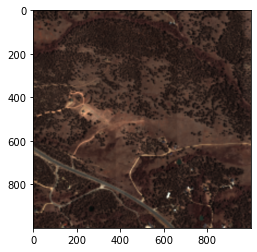

<Catalog id=catalog>

In [83]:
from shapely.geometry import Polygon, mapping
import shapely
#from pyproj import Proj
import datetime
from pyproj import CRS
from pyproj import Transformer

#input_proj = resamp_metadata_dict['Proj4']

# file_path = Path(r"..\data\Skywatch\catalog")
# file_path


# stuff to add to an initial function declaration call


# create the catalog
catalog = pystac.Catalog(id='catalog', description='Simulated satellite data catalog.')

# params for STAC item
# ------------------------------------------------------------------------------------

utm_crs = CRS.from_epsg(resamp_metadata_dict['EPSG Code'].item().decode('UTF-8')) # UTm coordinate system
latlon_crs = CRS.from_epsg('4326') # lat/lon coordiante system

coords_utm = [] # input UTM coordinates
coords_utm.append((resamp_metadata_dict['spatial extent'][0],resamp_metadata_dict['spatial extent'][2]))
coords_utm.append((resamp_metadata_dict['spatial extent'][0],resamp_metadata_dict['spatial extent'][3]))
coords_utm.append((resamp_metadata_dict['spatial extent'][1],resamp_metadata_dict['spatial extent'][2]))
coords_utm.append((resamp_metadata_dict['spatial extent'][1],resamp_metadata_dict['spatial extent'][3]))

transformer = Transformer.from_crs(utm_crs, latlon_crs) #transformer from UTM to lat/lon
#coords_latlon = [] # output lat/lon coordinates
lats = []
lons = []

for coords in coords_utm:
    points = transformer.transform(coords[0],coords[1])
    #coords_latlon.append(points)
    lats.append(points[0])
    lons.append(points[1])

coords_latlon = list(zip(lats,lons))

bounds_right = max(lons)
bounds_left = min(lons)
bounds_top = max(lats)
bounds_bottom = min(lats)

bbox = [bounds_left, bounds_bottom, bounds_right, bounds_top] # this will need to be  updated later

polygon = mapping(Polygon([
                    [bounds_left, bounds_bottom],
                    [bounds_left, bounds_top],
                    [bounds_right, bounds_top],
                    [bounds_right, bounds_bottom]
                ]))



# add the main STAC item
item = pystac.Item(id=filename_prefix,
                 geometry=polygon,
                 bbox=bbox,
                 datetime=timestamp,
                 properties={
                            "license": "proprietary",
                            #"datetime": "2021-12-09T21:33:31.158193", # are these the 
                            #"start_datetime": "2021-12-09T21:33:29.885445",
                            #"end_datetime": "2021-12-09T21:33:32.430941",
                            "datetime": str(timestamp),
                            "start_datetime": str(start_timestamp),
                            "end_datetime": str(end_timestamp),
                            "providers": [{
                                    "name": "Wyvern Space",
                                    "roles": [
                                        "producer",
                                        "licensor"
                                    ],
                                    "url": "https://www.wyvern.space/"
                                }
                            ],
                            "platform": "Dragonette-Sim",
                            "constellation": "imagineDragonette",
                            "instruments": ["Hyperspectral-imager"],
                            "sensor_mode": "strip",
                            "sensor_type": "optical",
                            "product_type": "hyperspectral",
                            "created": "2021-05-04T00:00:01Z", # are these meant to be when the product was first created? or the satellite launched/operational?
                            "updated": "2021-05-05T00:30:55Z",
                            "gsd": resamp_metadata_dict['Spatial_Resolution_X_Y'][0],
                            "sat:orbit_state": "descending",
                            "sat:relative_orbit": 4,   
                 },
                 stac_extensions = [pystac.Extensions.EO, pystac.Extensions.VIEW, pystac.Extensions.SAT] # add these in later: view & eo
                  )

catalog.add_item(item)

# ------------------------------------------------------------------------------
# set extension parameters

# view parameters - no data yet
item.ext.view.sun_azimuth = -9999
item.ext.view.sun_elevation = -9999
item.ext.view.off_nadir = -9999
item.ext.view.incidence_angle = -9999
item.ext.view.azimuth = -9999

# sat parameters
#item.ext.sat.orbit_state = "descending"
item.ext.sat.relative_orbit = 9999

# eo parameters
item.ext.eo.cloud_cover = -9999

# -----------------------------------------------------------------------------------
# create bands info on EO
from pystac.extensions.eo import Band

desired_band_centres = [0.505, 0.526, 0.544, 0.565, 0.586, 
                        0.606, 0.626, 0.646, 0.665, 0.682, 0.699,
                        0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804
                       ]
common_band_names = ['green1','green2','green3','green4','yellow',
                     'red1','red2','red3','red4','red5','red6',
                     'rededge1','rededge2','rededge3',
                     'nir1','nir2','nir3','nir4'
                    ]
                     
fwhm = np.round(downSampler.band_widths(desired_band_centres),3)
img_bands = []
    
for band in range(resamp_refl_array.shape[2]):

    img_bands.append(Band.create(
                name='Band_'+str(band+1).zfill(3), 
                common_name = common_band_names[band],
                center_wavelength = desired_band_centres[band],
                full_width_half_max = fwhm[band],
                #gain = -9999,
                #offset = -9999,
                #esun = -9999,
                #raster_width = resamp_refl_array.shape[0],
                #raster_height = resamp_refl_array.shape[1] 
               ))

#item.ext.eo.apply(bands=img_bands) # another way to set
item.ext.eo.set_bands(img_bands)
# -----------------------------------------------------------------------------------


img_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog'

# WYVERN_DE_20211209T2133_OJcjZkG_band3.tif

#band_num = len(resamp_refl_array[0,0,:])
# ----------------------------------------------------------------------------
# make the assets

for band in range(resamp_refl_array.shape[2]):
    band_name =  'Band_' + str(band+1).zfill(3) + '.tif' # make into e.g. 001 or 013 instead of 1 or 13 etc.
    #file_name = 'geotiff_method2_TEST_output Band_' + str(band+1).zfill(3) + '.tif' # UPDATE FILE NAME
    file_name = filename_prefix + '_' + 'band_' + str(band+1).zfill(3) + '.tif' # UPDATE FILE NAME
    filename_prefix
    print('creating asset for ' + band_name)

    # add the STAC assets
    item.add_asset(
                    key = band_name, 
                    asset = pystac.Asset(
                        title = common_band_names[band],
                        #href = os.path.join(img_path, file_name),
                        href = file_name,
                        media_type=pystac.MediaType.GEOTIFF,
                        roles = ["reflectance"]
                    )
    )
    
    
# add the preview asset
item.add_asset(
                key = filename_prefix+'_preview', 
                asset = pystac.Asset(
                    title = 'Preview',
                    #href = os.path.join(img_path, file_name),
                    href = filename_prefix+'_preview',
                    media_type=pystac.MediaType.PNG,
                    roles = ["overview"]
                )
)
downSampler.toRGB(resamp_refl_array, filename_prefix+'_preview.png', mode=2) # WYVERN_DS_20210517T162735_1KhCotz_preview
    
    
#catalog.normalize_hrefs(os.path.join(img_path, 'stac'))
catalog.normalize_hrefs(img_path)


    

In [78]:
import json
print(json.dumps(item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0-beta.2",
    "id": "WYVERN_DS_20210517T162735_1KhCotz",
    "properties": {
        "license": "proprietary",
        "datetime": "2021-05-17T16:27:35.357540Z",
        "start_datetime": "2021-05-17 16:27:30.357540",
        "end_datetime": "2021-05-17 16:27:40.357540",
        "providers": [
            {
                "name": "Wyvern Space",
                "roles": [
                    "producer",
                    "licensor"
                ],
                "url": "https://www.wyvern.space/"
            }
        ],
        "platform": "Dragonette-Sim",
        "constellation": "imagineDragonette",
        "instruments": [
            "Hyperspectral-imager"
        ],
        "sensor_mode": "strip",
        "sensor_type": "optical",
        "product_type": "hyperspectral",
        "created": "2021-05-04T00:00:01Z",
        "updated": "2021-05-05T00:30:55Z",
        "gsd": 5.0,
        "sat:orbit_state": "descending",
      

In [79]:
catalog.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [ ]:
# debugging & help below

In [68]:
print(list(catalog.get_children()))
print(list(catalog.get_items()))

[]
[<Item id=WYVERN_DS_20210516T182703_PoRTPKs>]


In [69]:
print(catalog.get_self_href())
print(item.get_self_href())

C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\catalog.json
C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210516T182703_PoRTPKs\WYVERN_DS_20210516T182703_PoRTPKs.json


In [70]:
print(catalog.links)
print(item.links)

[<Link rel=root target=<Catalog id=catalog>>, <Link rel=item target=<Item id=WYVERN_DS_20210516T182703_PoRTPKs>>, <Link rel=self target=C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\catalog.json>]
[<Link rel=root target=<Catalog id=catalog>>, <Link rel=self target=C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\WYVERN_DS_20210516T182703_PoRTPKs\WYVERN_DS_20210516T182703_PoRTPKs.json>, <Link rel=parent target=<Catalog id=catalog>>]


In [71]:
catalog.describe() # walk the STAC tree of the catalog and show us everything

* <Catalog id=catalog>
  * <Item id=WYVERN_DS_20210516T182703_PoRTPKs>


In [72]:
print(catalog.get_self_href() is None)
print(item.get_self_href() is None)

False
False


In [ ]:
print(pystac.Item.__doc__)

In [ ]:
# from https://github.com/stac-utils/pystac/blob/b005962ebb82da5c244d8f95309f1a4fcf4146a3/docs/tutorials/how-to-create-stac-catalogs.ipynb

# import rasterio
# from shapely.geometry import Polygon, mapping

# def get_bbox_and_footprint(raster_uri):
# #     with rasterio.open(raster_uri) as ds:
# #         bounds = ds.bounds
#     bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
#     footprint = Polygon([
#         [bounds.left, bounds.bottom],
#         [bounds.left, bounds.top],
#         [bounds.right, bounds.top],
#         [bounds.right, bounds.bottom]
#         ])
        
#     return (bbox, mapping(footprint))

### End of STAC

In [ ]:
# from pystac import Catalog

# cat = Catalog.from_file('https://sentinel-stac.s3.amazonaws.com/catalog.json')

In [ ]:
import pystac
import geojson as gj

#Path(r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch")
gjson_filepath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog"
gjson_filename = "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json"

#cat = ps.Catalog.from_file(gjson_file)

meta_feature = gj.Feature("type": "Feature","id": "WYVERN_DE_20211209T2133_OJcjZkG",) # change ID name 

In [ ]:
# json files

data = {
    "president": {
        "name": "Zaphod Beeblebrox",
        "species": "Betelgeusian"
    }
}


### STAC Extensions enabled:

- view
- eo

In [ ]:
import geojson

gjson_filepath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog"
gjson_filename = "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json"

with open(gjson_filepath + "\\" + gjson_filename) as f:
    gj = geojson.load(f)
#features = gj['features'][0]
gj

In [ ]:
gj['assets']

In [ ]:
def metadata2geojson():
    '''
    Make a metadata geojason
    '''
    
    
    !mkdir -p ./quickstart_stac
    
    

### Change Log

- Split output hdf5 image into separate bands
- Coordinates added to output HDF5 file
- Convert to GeoTiff functionality

## Questions for Skywatch:

- __Q__: Does Skywatches standard implement all of the STAC stardards (Item, Catalog, Collection, API)? - Looks like yes
- __Q__: In HDF5 its seems common practice to store reflectance values scaled up by ~10,000 in order to store them as integers - is the same done in the GeoTIFF?
    - __Q__:This is fine if you are concerned with minimizing the storage size
- __Q__: Do we need to generate the catalog & collection parts of geojson or is this handled by Skywatch's backend when new image files are uploaded?
 - __Q__: On that note what is the process for uploading files to the Skywatch platform, manual? API?
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json" - Metadata:
    - __Q__: Where do you define the CRS used? Lon/lat coordinates given but are they WGS84?
    - __Q__: for the usable data mask assest (UDM) is this where information about no data values (9999) are stored? or is it like a boolean mask over the image indicating data/no data?
    - __Q__: Is any metadata stored with the .tiff file(s) itself or all in the STAC metadata json file?
    - __Q__: It looks like each raster image layer is separate .tiff?
    - __Q__: If we don't currently have some of the metadata items what would you recommend we do? Leave those out? Generate but leave the value blank? (We are using sensor data from an air platform that undergoes processing to simulate satellite imagery so won't have things like orbital state vectors etc.)
    - How much of the metadata to use from NEON and how much should be from our planned satellite? - e.g. for the satellite parameters
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_rpc.json" - Rational Polynomial Coefficients (RPCs) - do we have these? (Compact representation of camera model for photogrammetry)
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_eph.json" - Orbital state vectors - don't have these from the NEON aircraft data - do we have/would we need to simulate satellite's orbit to generate?




Per product we only care about the Item spec
a) the lat/lon in the Stac metadata are to aid searches. The actual CRS should be in the GeoTiffs
b) the UDM is useful if you have other bits to accompany each pixel like a cloud mask, quality or something else. If your processing won’t include these then we may not need it since the no data values can also be represented in the GeoTiffs
c) For multispectral all bands could be in the same GeoTiff but, for hyperspectral it may be easier to select, download and process a subset of bands as needed.
d) The GeoTiffs should have the standard tags for the CRS and possibly the gdal no data value tag
e) It’s probably best for our communication to include them and populate them with something representing no data. Strings could be empty, numeric values could be -9999


- Q: Is there a preference for the CRS system used? UTM? Lon/Lat - lean towards UTM for now


TODO:

- get geotiff working and readable in python and QGIS
- write geojason metadata output file functionality
       - convert UTM coordinates into lon,lat coordinates
- Proj4 metadata file?
- Submit questions to Skywatch and Alex about metadata



- Adapt output code to output to GeoTIFF format - 
- fix coordinates - Done
- Find out specification of SkyWatches data format, GeoTIFF? COG/COGeoTIFF? (Cloud-optimized GeoTIFF) - DONE See below:

If you already have a sample product structure we could work with it. We would primarily like that the raster image be in COG GeoTiff so they are easy to clip.
If you're just start to package something then it would be ideal if the product format could follow STAC for the metadata and COG GeoTiff for the raster images.
- https://stacspec.org/
- https://www.cogeo.org/
- RPCs should follow the NITF RPC00B
- http://everyspec.com/DoD/DoD-PUBLICATIONS/STDI-0002_v2--1-_CE_for_NITFS_2994/
- I could send you an example product if you like




- TEST!
    - QGIS
    - ENVI tool: https://www.l3harrisgeospatial.com/Software-Technology/ENVI
    - ERDAS ER Mapper 2020 tool: https://download.hexagongeospatial.com/en/downloads/imagine/erdas-er-mapper-2020
 

# ------------------------------ WIP After This Point --------------------------------------------

In [ ]:
# count = 0
# for i in range(1, len(refl_array[0,0,:])+1):
#     count += 1
#     #print(i)
# print('count',count)

In [ ]:
# import os
# import gdal

# file = "path+filename"
# ds = gdal.Open(file)
# band = ds.GetRasterBand(1)
# arr = band.ReadAsArray()
# [cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = numpy.where((arr < arr_mean), 10000, arr)
# driver = gdal.GetDriverByName("GTiff")
# outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
# outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
# outdata.SetProjection(ds.GetProjection())##sets same projection as input
# outdata.GetRasterBand(1).WriteArray(arr_out)
# outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
# outdata.FlushCache() ##saves to disk!!
# outdata = None
# band=None
# ds=None